In [1]:
import scipy.io
import numpy as np
import itertools
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from random import randint
import sklearn.linear_model as linear_model
import sklearn.preprocessing as prep
import math
from sklearn.pipeline import make_pipeline
from scipy import stats
import csv
from sklearn import metrics


In [2]:
## import dataset
mat = scipy.io.loadmat('SSVEPDataset.mat')
data = mat['subject'][0]
number_of_subjects = len(data)
number_of_conditions = len(data[0])
number_of_samplings = len(data[0][0])
print "Data includes", number_of_subjects, "subjects :"
print "(", number_of_conditions, "conditions per subject )"
print "(", number_of_samplings, "samplings per condition )"
#print data

Data includes 12 subjects :
( 5 conditions per subject )
( 15000 samplings per condition )


In [99]:
## select one condition data and filter out first 10-second data
#set params
condition_id = 4 # ( 1 to 5 )
number_of_samplings_per_sec = 250
filtered_secs = 9
all_secs = number_of_samplings/number_of_samplings_per_sec
used_secs = all_secs - filtered_secs
number_of_filter_out_samplings = number_of_samplings_per_sec * filtered_secs
print "Parameter setting : all =", all_secs, "seconds, used = ", used_secs, "seconds" 

#get data
data_selected = np.zeros((number_of_subjects, number_of_samplings-number_of_filter_out_samplings))
for i, d in enumerate(data):
    #one loop is one subject
    join_list = list(itertools.chain.from_iterable(d[condition_id-1]))
    
    #bandpass filter
    nyq = 0.5 * number_of_samplings_per_sec
    low = 7 / nyq
    high = 8 / nyq
    order = 2
    b, a = butter(order, [low, high], btype='band')
    f = lfilter(b, a, join_list)
    
    #filter out first-nine second
    data_selected[i] = f[number_of_filter_out_samplings:]

print "Select data from condition #", condition_id
print "Size of data is", len(data_selected), "subjects with", len(data_selected[0]), "samplings per subject."

Parameter setting : all = 60 seconds, used =  51 seconds
Select data from condition # 4
Size of data is 12 subjects with 12750 samplings per subject.


Each subjects contains 47 windows.
==== FFT with subjects # 0 ====


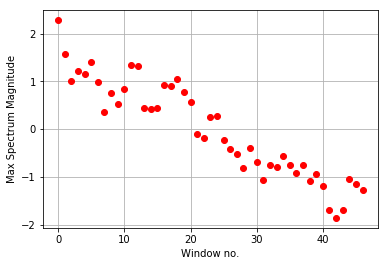

==== FFT with subjects # 1 ====


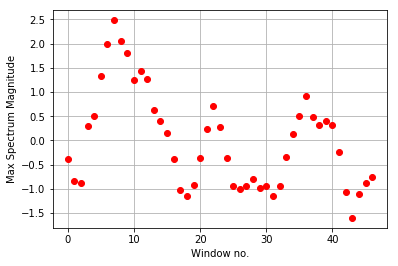

==== FFT with subjects # 2 ====


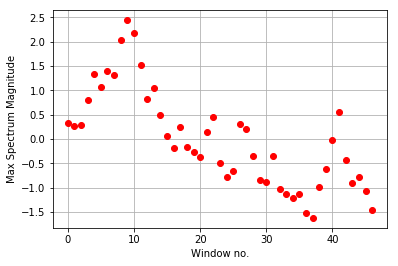

==== FFT with subjects # 3 ====


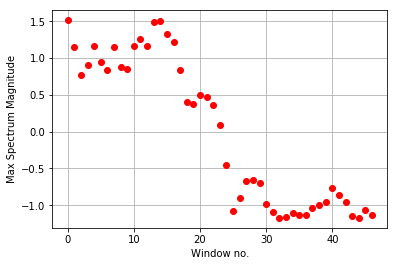

==== FFT with subjects # 4 ====


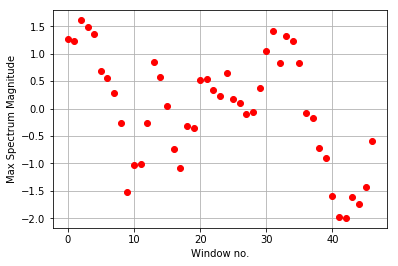

==== FFT with subjects # 5 ====


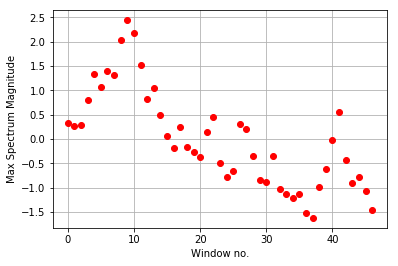

==== FFT with subjects # 6 ====


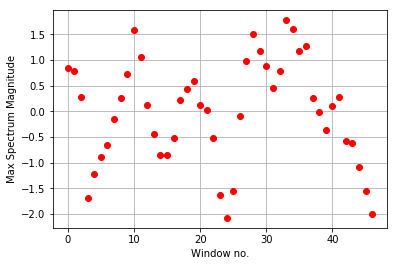

==== FFT with subjects # 7 ====


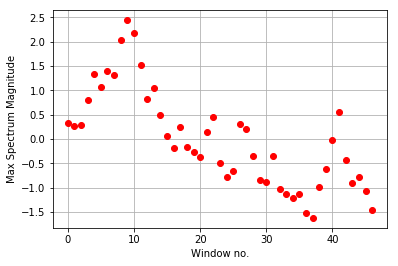

==== FFT with subjects # 8 ====


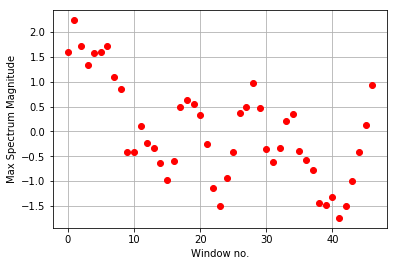

==== FFT with subjects # 9 ====


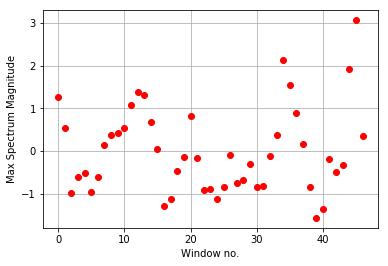

==== FFT with subjects # 10 ====


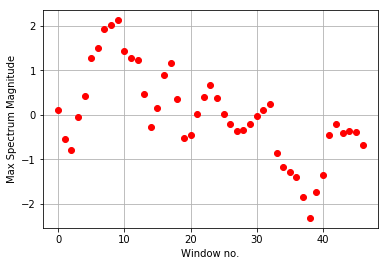

==== FFT with subjects # 11 ====


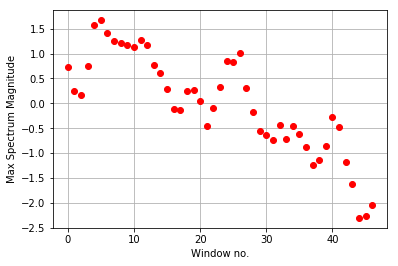

In [100]:
## perform Fast Fourier Transform (FFT)
#set params
window_size = 5 #seconds
number_of_slide_windows = used_secs-window_size+1
fft_out_max_list = np.zeros((number_of_subjects, number_of_slide_windows))
print "Each subjects contains", number_of_slide_windows, "windows."

#FFT
for i, d in enumerate(data_selected):
    print "==== FFT with subjects #", i, "===="
    for index in range(0, number_of_slide_windows):
        #one loop per window
#         print "From second #", index, "to", index+window_size-1,"( sampling no.", index*number_of_samplings_per_sec, "to", (index + window_size) * number_of_samplings_per_sec - 1, ")"
        
        #FFT
        fft_out = fft(d[index*number_of_samplings_per_sec : (index + window_size) * number_of_samplings_per_sec])
        
        #z-score normalization
        #fft_out = stats.zscore(fft_out)
        
        """
        #manual normalization (results are equal to above)
        mean = np.mean(fft_out)
        std = np.std(fft_out)
        fft_out = [ (f-mean)/std for f in fft_out ]
        """
        
        freqs = fftfreq(len(fft_out)) * number_of_samplings_per_sec
        
        #Get maximum magnitude value from window_size freq
        if window_size == 4:
            fix_freq = 7.5
        elif window_size == 5:
            fix_freq = 7.6
        elif window_size == 6:
            fix_freq = 7.5
        elif window_size == 8:
            #still cannot find fix freq
            #peak is around 7.56-7.58
            #but after find from 7.5 to 7.8 (with scale + 0.00001), I still cannot find it
            fix_freq = 7.5
        elif window_size == 10:
            fix_freq = 7.6

        fft_out_max_list[i][index] = np.abs(fft_out)[np.where(freqs==fix_freq)]
        
        """ 
        if index == number_of_slide_windows - 1:
            #plot FFT of some specific window
            fig, ax = plt.subplots()
            ax.plot(freqs, np.abs(fft_out))
            ax.set_xlabel('Frequency in Hertz [Hz]')
            ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
            ax.set_xlim(1, 10)
            ax.set_ylim(1, 40)
            plt.grid()
            plt.show() 
        """
            
    #z-score normalization
    fft_out_max_list[i] = stats.zscore(fft_out_max_list[i])   
    
        
    plt.plot(fft_out_max_list[i], 'ro')
    plt.xlabel('Window no.')
    plt.ylabel('Max Spectrum Magnitude')
    plt.grid()
    plt.show()
    

In [101]:
def write_result_to_csv(filename, results):
    print 'Start writing results from', len(results[0]), 'subjects'
    csvfile1 = open(filename + '_RMSE.csv', 'wb')
    csvfile2 = open(filename + '_testscore.csv', 'wb')
    
    wr1 = csv.writer(csvfile1, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    wr2 = csv.writer(csvfile2, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
    wr1.writerow(['subject_id', 'RMSE_'+str(reduce_result_proportion[0]*100)+'%', \
                  'RMSE_'+str(reduce_result_proportion[1]*100)+'%', \
                  'RMSE_'+str(reduce_result_proportion[2]*100)+'%'])
    wr2.writerow(['subject_id', 'testscore_'+str(reduce_result_proportion[0]*100)+'%', \
              'testscore_'+str(reduce_result_proportion[1]*100)+'%', \
              'testscore_'+str(reduce_result_proportion[2]*100)+'%'])
    
    for i in range(0, number_of_subjects):
        wr1.writerow([i, results[0][i]['RMSE'], results[1][i]['RMSE'], \
                      results[2][i]['RMSE']])
        wr2.writerow([i, results[0][i]['test_score'], results[1][i]['test_score'], \
                      results[2][i]['test_score']])
    
    csvfile1.close()
    csvfile2.close()
    
    print 'Finish writing :', filename

In [102]:
def write_avg_result_to_csv(filename, results):
    print 'Start writing avg results from', len(results[0]), 'subjects'
    csvfile1 = open(filename + '_RMSE.csv', 'wb')
    csvfile2 = open(filename + '_testscore.csv', 'wb')
    
    wr1 = csv.writer(csvfile1, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    wr2 = csv.writer(csvfile2, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
    for i in range(0, number_of_subjects):
        wr1.writerow([i, results[0]['RMSE'][i]])
        wr2.writerow([i, results[0]['test_score'][i]])
    
    csvfile1.close()
    csvfile2.close()
    
    print 'Finish writing :', filename

In [103]:
def train_test_split(x, y, test_size = 1, fix_subject = None):
    
    r = []
    if fix_subject == None:
        while True:
            status = False
            for i in range(test_size):
                rand = 0
                while True:
                    rand = randint(0, number_of_subjects-1)
                    if rand not in r:
                        break
                    else:
                        print rand, r
                r.append(rand)

            for ri in rand_indices:
                if set(ri) == set(r):
                    r = []
                    status = True
                    break

            if not status:
                break
    else:
        r = [fix_subject]
            
            
    print "Random result: subject #", r, "is test set."
    rand_indices.append(r)
    
    x_test = np.array([x[i] for i in r]).reshape(-1,1)
    x_train = np.array([x[i] for i in range(number_of_subjects) if i not in r]).reshape(-1,1)
    y_test = y[1:test_size+1]
    y_test = np.concatenate(y_test)
    y_train = y[1:number_of_subjects-test_size+1]
    y_train = np.concatenate(y_train)
    
    return x_train, \
            x_test, \
            y_train, \
            y_test, \
            r

In [104]:
def plot_avg_curve(fft_out, cond, degree):
    
    avg = np.mean(fft_out, axis = 0)
    time_steps = [x for x in range(0, number_of_slide_windows)]
    yerr = np.std(fft_out, axis=0) / math.sqrt(number_of_subjects)
    
    #curve fit
    coef = np.polyfit(time_steps, avg, degree)
    ffit = np.poly1d(coef)
    ys = []
    for a in time_steps:
        ys.append(ffit(a))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(time_steps, ys, lw=2.5, color="#424949")
    
    #plot errorbar
    ax.errorbar(time_steps, avg, yerr, linestyle='None', \
                 fmt='o', markersize=2, color='r', capsize=2, lw=1)
    
    plt.xlabel('Normalized SSVEP', fontsize=12, fontweight='bold')
    plt.ylabel('Light Intensity', fontsize=12, fontweight='bold')
    #ax.set_ylim(-1.75, 1.75)
    #plt.show()
    plt.savefig('./results/' + str(cond) + '.png')
    
    return ys

In [105]:
def get_rmse_avg(y_true, y_pred):
    RMSEs = np.zeros(shape = (number_of_subjects,1))
    
    for i in range(number_of_subjects):
        RMSEs[i] = np.sqrt(np.sum(np.square(y_pred-y_true[i]))/ len(y_true[i]))
    
    return RMSEs

In [106]:
def get_r2_avg(y_true, y_pred):
    R2s = np.zeros(shape = (number_of_subjects,1))
    
    for i in range(number_of_subjects):
        R2s[i] = metrics.r2_score(y_true[i], y_pred)
    
    return R2s

[[255 252 249 246 243 240 237 234 231 228 225 222 219 216 213 210 207 204
  201 198 195 192 189 186 183 180 177 174 171 168 165 162 159 156 153 150
  147 144 141 138 135 132 129 126 123 120 117]
 [255 252 249 246 243 240 237 234 231 228 225 222 219 216 213 210 207 204
  201 198 195 192 189 186 183 180 177 174 171 168 165 162 159 156 153 150
  147 144 141 138 135 132 129 126 123 120 117]
 [255 252 249 246 243 240 237 234 231 228 225 222 219 216 213 210 207 204
  201 198 195 192 189 186 183 180 177 174 171 168 165 162 159 156 153 150
  147 144 141 138 135 132 129 126 123 120 117]
 [255 252 249 246 243 240 237 234 231 228 225 222 219 216 213 210 207 204
  201 198 195 192 189 186 183 180 177 174 171 168 165 162 159 156 153 150
  147 144 141 138 135 132 129 126 123 120 117]
 [255 252 249 246 243 240 237 234 231 228 225 222 219 216 213 210 207 204
  201 198 195 192 189 186 183 180 177 174 171 168 165 162 159 156 153 150
  147 144 141 138 135 132 129 126 123 120 117]
 [255 252 249 246 243 240

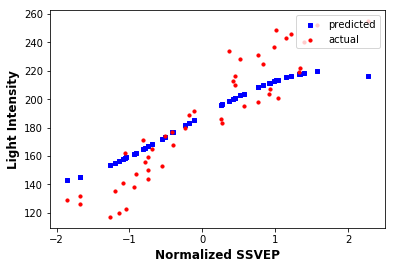

Random result: subject # [1] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 1 , RMSE: 38.53266574806792 , test_score: 0.8965980251523714


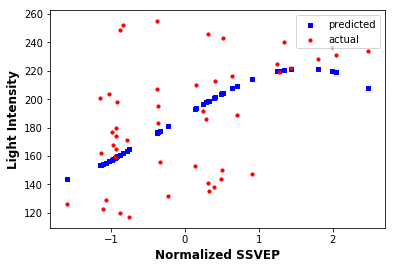

Random result: subject # [2] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 2 , RMSE: 26.76085962104296 , test_score: 0.43245386935819297


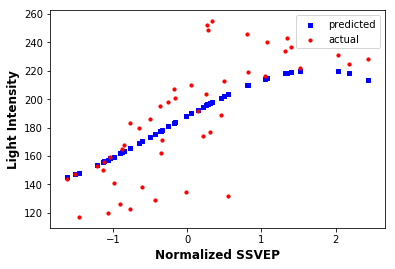

Random result: subject # [3] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 3 , RMSE: 20.412184530093857 , test_score: 0.2516046360450501


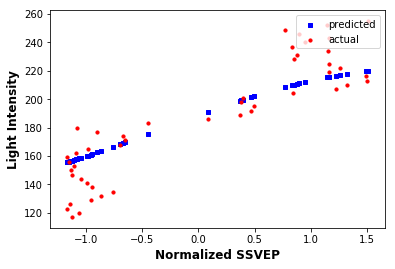

Random result: subject # [4] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 4 , RMSE: 37.4164063376602 , test_score: 0.845403057502958


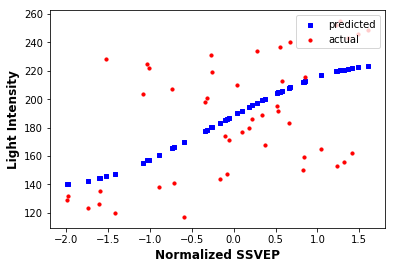

Random result: subject # [5] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 5 , RMSE: 26.760859621042965 , test_score: 0.4324538693581932


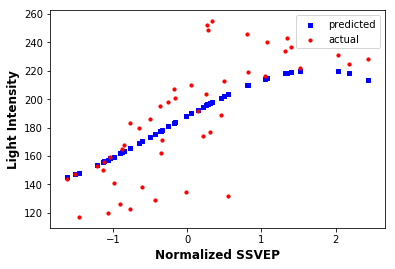

Random result: subject # [6] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 6 , RMSE: 48.61451165075633 , test_score: 1.4271562457980207


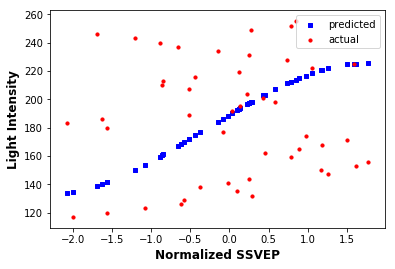

Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 7 , RMSE: 26.760859621042957 , test_score: 0.43245386935819297


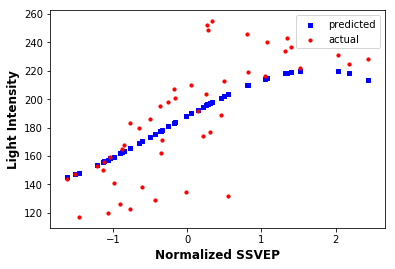

Random result: subject # [8] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 8 , RMSE: 33.82830769394291 , test_score: 0.6910352665676793


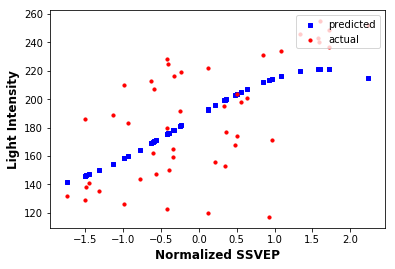

Random result: subject # [9] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 9 , RMSE: 47.71025119732636 , test_score: 1.3745580128695538


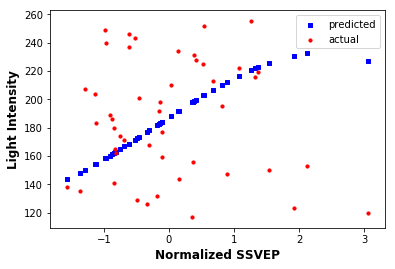

Random result: subject # [10] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 10 , RMSE: 31.608352383589477 , test_score: 0.6033139736746174


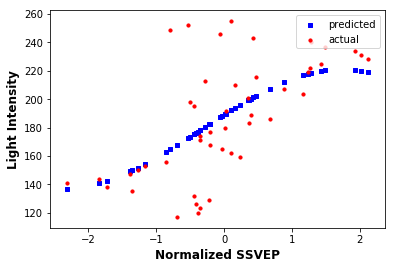

Random result: subject # [11] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 11 , RMSE: 23.683888098172247 , test_score: 0.3387237653663919


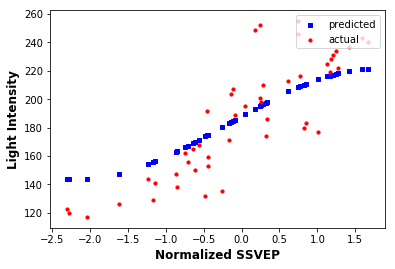

Store results of 12 subjects done!

#### Begin calculate with result proportion = 1 ####
Random result: subject # [0] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 0 , RMSE: 19.60295225043299 , test_score: 0.23205056578064964


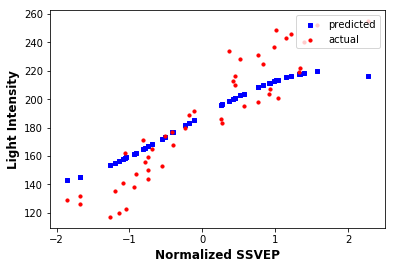

Random result: subject # [1] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 1 , RMSE: 38.53266574806792 , test_score: 0.8965980251523714


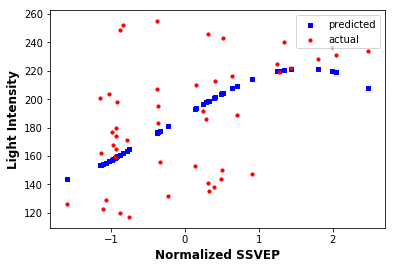

Random result: subject # [2] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 2 , RMSE: 26.76085962104296 , test_score: 0.43245386935819297


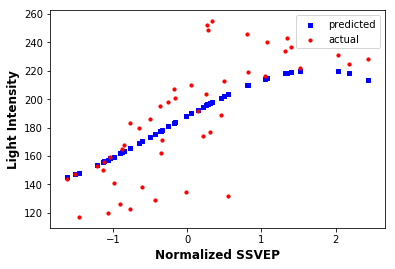

Random result: subject # [3] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 3 , RMSE: 20.412184530093857 , test_score: 0.2516046360450501


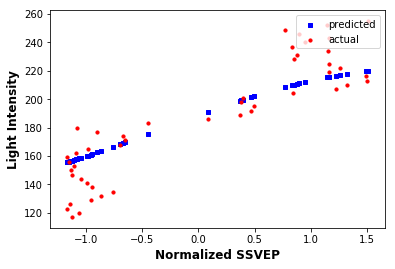

Random result: subject # [4] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 4 , RMSE: 37.4164063376602 , test_score: 0.845403057502958


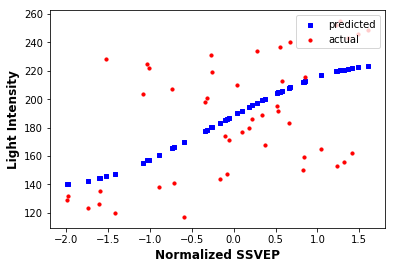

Random result: subject # [5] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 5 , RMSE: 26.760859621042965 , test_score: 0.4324538693581932


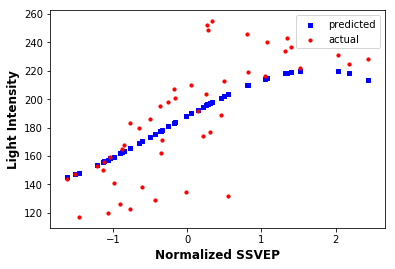

Random result: subject # [6] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 6 , RMSE: 48.61451165075633 , test_score: 1.4271562457980207


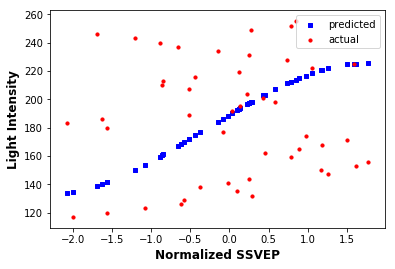

Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 7 , RMSE: 26.760859621042957 , test_score: 0.43245386935819297


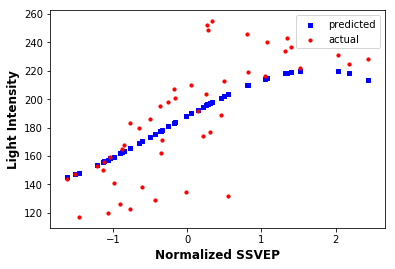

Random result: subject # [8] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 8 , RMSE: 33.82830769394291 , test_score: 0.6910352665676793


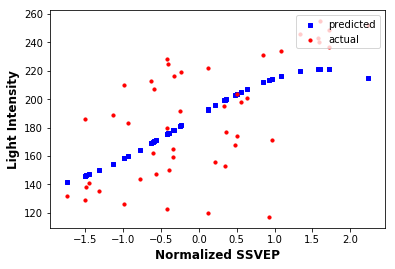

Random result: subject # [9] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 9 , RMSE: 47.71025119732636 , test_score: 1.3745580128695538


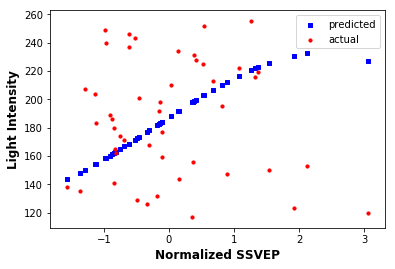

Random result: subject # [10] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 10 , RMSE: 31.608352383589477 , test_score: 0.6033139736746174


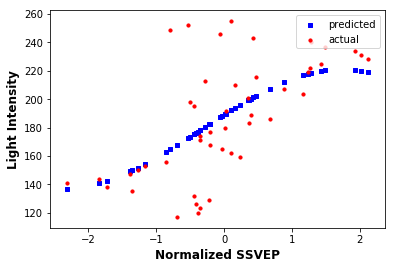

Random result: subject # [11] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 11 , RMSE: 23.683888098172247 , test_score: 0.3387237653663919


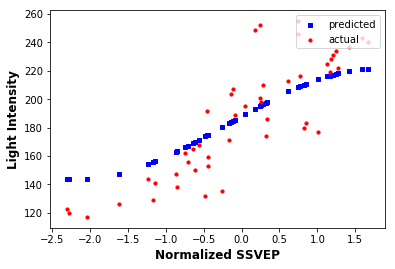

Store results of 12 subjects done!

#### Begin calculate with result proportion = 1 ####
Random result: subject # [0] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 0 , RMSE: 19.60295225043299 , test_score: 0.23205056578064964


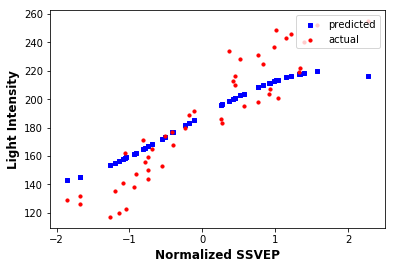

Random result: subject # [1] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 1 , RMSE: 38.53266574806792 , test_score: 0.8965980251523714


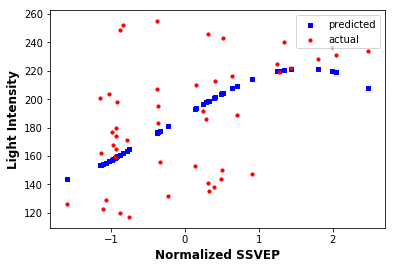

Random result: subject # [2] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 2 , RMSE: 26.76085962104296 , test_score: 0.43245386935819297


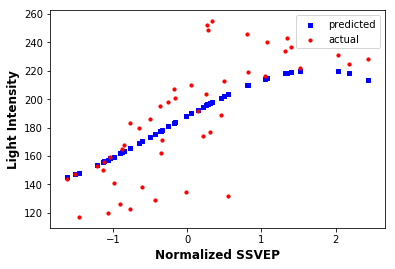

Random result: subject # [3] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 3 , RMSE: 20.412184530093857 , test_score: 0.2516046360450501


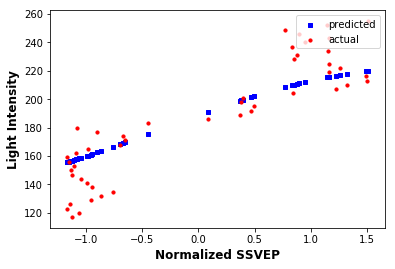

Random result: subject # [4] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 4 , RMSE: 37.4164063376602 , test_score: 0.845403057502958


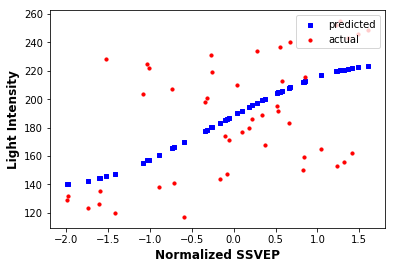

Random result: subject # [5] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 5 , RMSE: 26.760859621042965 , test_score: 0.4324538693581932


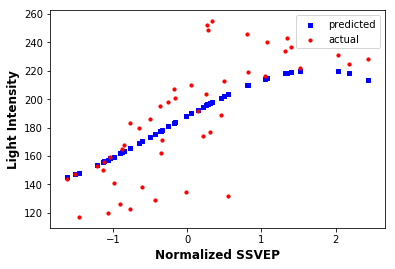

Random result: subject # [6] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 6 , RMSE: 48.61451165075633 , test_score: 1.4271562457980207


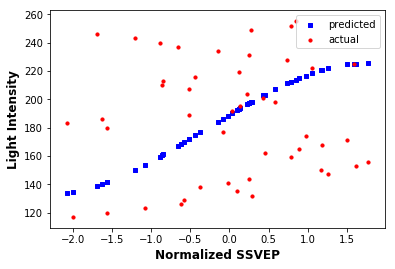

Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 7 , RMSE: 26.760859621042957 , test_score: 0.43245386935819297


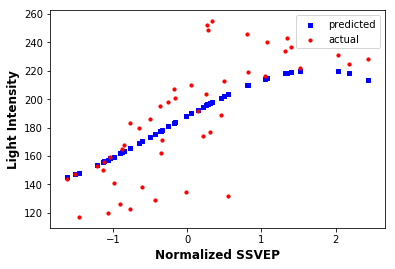

Random result: subject # [8] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 8 , RMSE: 33.82830769394291 , test_score: 0.6910352665676793


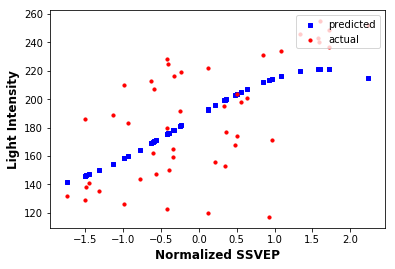

Random result: subject # [9] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 9 , RMSE: 47.71025119732636 , test_score: 1.3745580128695538


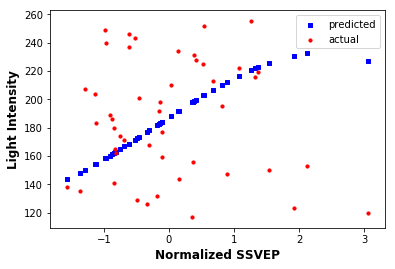

Random result: subject # [10] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 10 , RMSE: 31.608352383589477 , test_score: 0.6033139736746174


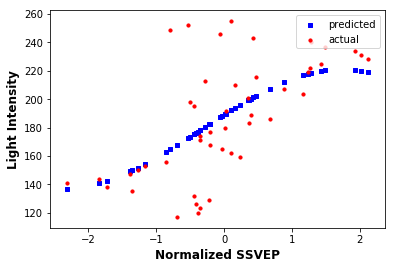

Random result: subject # [11] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 11 , RMSE: 23.683888098172247 , test_score: 0.3387237653663919


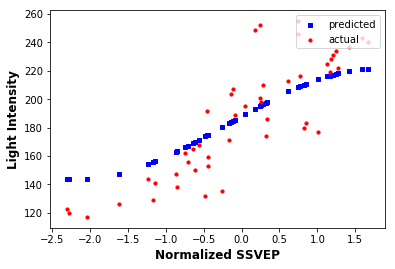

Store results of 12 subjects done!

Start writing results from 12 subjects
Finish writing : ./results/train_con4


In [112]:
## Non-Linear Regression by me

# set params
test_set_fraction = 1.0/12
test_size = 1
rand_indices = []
results = []
number_of_cv_rounds = number_of_subjects
intensity_step = 3
degree=3

# setting light intensity data
if condition_id == 5:
    first_light_intensity_begin = 150
    last_light_intensity_begin = 255
    light_intensity_up = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
    light_intensity_down = np.arange(last_light_intensity_begin, first_light_intensity_begin, -(intensity_step))
    light_intensity = np.concatenate([light_intensity_up, light_intensity_down])[0:number_of_slide_windows]
    last_light_intensity_begin = light_intensity[len(light_intensity)-1]
    light_intensity = np.tile(light_intensity,(number_of_subjects,1))
elif condition_id == 4:
    first_light_intensity_begin = 255
    last_light_intensity_begin = 0
    light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, -(intensity_step))
    light_intensity = light_intensity[0:number_of_slide_windows]
    last_light_intensity_begin = light_intensity[len(light_intensity)-1]
    light_intensity = np.tile(light_intensity,(number_of_subjects,1))
else:
    first_light_intensity_begin = 75
    last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
    light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
    light_intensity = np.tile(light_intensity,(number_of_subjects,1))

print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
        ", end at intensity =", last_light_intensity_begin, \
        ", cross validation =", number_of_cv_rounds
print

selected_data_start = 25
selected_data_end = 45

## prepare list to store results
results = []
reduce_result_proportion = [1, 1, 1]
filename = './results/train_con' + str(condition_id)

for c, r in enumerate(reduce_result_proportion):
    print '#### Begin calculate with result proportion =', r, '####'
    results.append([])
    y_true_all = []
    y_pred_all = []
    
    for i in range(0, number_of_cv_rounds):
        X_train, X_test, y_train, y_test, subject_id = train_test_split(x = fft_out_max_list, y = light_intensity, \
                                                                test_size=test_size, fix_subject = i)
        
        
        print "X_train :", len(X_train), ", X_test :", len(X_test), ", y_train :", len(y_train), ", y_test :", len(y_test)
        print
        
#         X_train = X_train[:int(len(X_train)*r)]
#         X_test = X_test[:int(len(X_test)*r)]
#         y_train = y_train[:int(len(y_train)*r)]
#         y_test = y_test[:int(len(y_test)*r)]

#         X_train = X_train[selected_data_start:selected_data_end]
#         X_test=X_test[selected_data_start:selected_data_end]
#         y_train = y_train[selected_data_start:selected_data_end]
#         y_test=y_test[selected_data_start:selected_data_end]   

        ## non-linear regression
        model = prep.PolynomialFeatures(degree)
        X_tr = model.fit_transform(X_train, y_train)
        X_te = model.fit_transform(X_test)

        clf = linear_model.LinearRegression()
        clf.fit(X_tr, y_train)
        y_pred = clf.predict(X_te)
        y_pred_all.append(y_pred)
        y_true_all.append(y_test)

        
        ##### uncomment this for calculate RMSE and R2 by each subject #####
        # calculate RMSE and R2
        test_score = 1 - clf.score(X_te,y_test)
        RMSE = np.sqrt(np.sum(np.square(y_pred-y_test))/ len(y_pred))
        print "Round :", i, ", RMSE:", RMSE, ", test_score:", test_score
        
        #store results
        results[c].append(dict({
            'subject_id' : subject_id,
            'RMSE' : RMSE,
            'test_score' : test_score
        }))

        ## plot non-linear regression result
        x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
        x = x[:int(len(x)*r)]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        
        ax1.scatter(np.concatenate(X_test), y_pred, s=10, c='b', marker="s", label='predicted')
        ax1.scatter(np.concatenate(X_test), y_test, s=10, c='r', marker="o", label='actual')
        plt.xlabel('Normalized SSVEP', fontsize=12, fontweight='bold')
        plt.ylabel('Light Intensity', fontsize=12, fontweight='bold')
        #ax1.set_ylim(70, 261)
        #ax1.set_xlim(-2, 2.5)
        ax1.legend(loc=1)
        #plt.show()
        plt.savefig('./results/train_' + str(condition_id) + '_' + str(subject_id) + '.png')
        plt.legend(loc='upper right');
        plt.show()
        ######################################################################
        
        
    """
    ##### uncomment this for calculate RMSE and R2 by averages #####
    y_pred_avg = plot_avg_curve(y_pred_all, condition_id, degree)
    RMSE_AVG = get_rmse_avg(y_pred_all, y_pred_avg)
    R2_AVG = get_r2_avg(y_pred_all, y_pred_avg)
    
    #store results
    results[c] = dict({
        'RMSE' : np.concatenate(RMSE_AVG),
        'test_score' : np.concatenate(R2_AVG)
    })
    ######################################################################
    """
    
    print 'Store results of', len(results[c]), 'subjects done!'
    print
    
write_result_to_csv(filename, results)

In [89]:
# ## Non-Linear Regression by Tutorial
# # Alpha (regularization strength) of LASSO regression
# lasso_eps = 0.001
# lasso_nalpha=20
# lasso_iter=1000

# # set params
# test_set_fraction = 1.0/12
# test_size = 1
# rand_indices = []
# number_of_cv_rounds = number_of_subjects
# intensity_step = 3
# first_light_intensity_begin = 105
# last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
# print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
#         ", end at intensity =", last_light_intensity_begin, \
#         ", cross validation =", number_of_cv_rounds
# print

# ## prepare list to store results
# tutorial_results = []
# reduce_result_proportion = [1, 0.5, 0.25]
# filename = './tutorial_results'

# # Test/train split
# light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
# light_intensity = np.tile(light_intensity,(number_of_subjects,1))

# for c, r in enumerate(reduce_result_proportion):
#     print '#### Begin calculate with result proportion =', r, '####'
#     tutorial_results.append([])
    
#     for i in range(0, number_of_cv_rounds):
#         # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, 
#         # run it for increasing degree of polynomial (complexity of the model)

#         model = make_pipeline(prep.PolynomialFeatures(degree=3, interaction_only=False), \
#                               linear_model.LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,\
#                                                    normalize=True,cv=number_of_cv_rounds))

#         X_train, X_test, y_train, y_test, subject_id = train_test_split(x = light_intensity, y = fft_out_max_list, \
#                                                                         test_size=test_size, fix_subject = i)
        
#         X_train = X_train[:int(len(X_train)*r)]
#         X_test = X_test[:int(len(X_test)*r)]
#         y_train = y_train[:int(len(y_train)*r)]
#         y_test = y_test[:int(len(y_test)*r)]
        
#         model.fit(X_train,y_train)
#         y_pred = np.array(model.predict(X_test))
#         RMSE = np.sqrt(np.sum(np.square(y_pred-y_test)) / len(y_pred))
#         test_score = model.score(X_test,y_test)

#         ## store results
#         tutorial_results[c].append(dict({
#             'subject_id' : subject_id,
#             'RMSE' : RMSE,
#             'test_score' : test_score
#         }))

#         ## plot non-linear regression result
#         x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
#         x = x[:int(len(x)*r)]
#         fig = plt.figure()
#         ax1 = fig.add_subplot(111)

#         ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
#         ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
#         plt.legend(loc='upper left');
#         plt.show()

#     print 'Store results of', len(tutorial_results[c]), 'subjects', len(x), 'points per subject done!'
#     print
    
# write_result_to_csv(filename, tutorial_results)

In [68]:
# ## try linear regression (not be used)
# model = linear_model.LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# #calculate Mean Square Error
# mse = np.sum(abs(y_pred-y_test)) / len(y_test)

# ## plot linear regression result (not be used)
# x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
# fig = plt.figure()
# ax1 = fig.add_subplot(111)

# ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
# ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
# plt.legend(loc='upper left');
# plt.show()